# Necessary Imports

In [125]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
import pickle
import time
import sys

# Webscraping
These code blocks create an instance of the webscraper object, and scrapes levelsfyi for its data using a selenium driver. This may take a little bit of time.


In [126]:
class WebScraper():
    def __init__(self):
        serv = Service('/usr/bin/chromedriver')
        self.auth = False
        self.driver = webdriver.Chrome(service=serv)
        self.salaries_list = []
        self.levels_list = []
        self.offer_date_list = []
        self.years_at_company_list = []
        self.years_of_experience_list = []
        self.soup = None

    # initializes the client to levels.fyi
    def initialize_client(self):
        url = 'https://www.levels.fyi/companies/google/salaries/software-engineer?offset=0'
        self.driver.get(url)
        return

    #function that removes the blur from the salary list
    def remove_blur(self):
        # click buttons to remove the blur from salary data
        self.driver.execute_script("document.querySelector('.css-kg5r73').scrollIntoView();")
        self.driver.execute_script("document.querySelector('.css-1q3lwpg').click();")
        self.driver.execute_script("document.querySelector('.css-boyo6o').click();")
        self.auth = True
        return

    #function to filter salaries to United States only
    def filter_country(self):
        # opening dropdown
        self.driver.execute_script("document.querySelector('.css-ch9u3p').click();")

        # scroll United States into view
        self.driver.execute_script("""
            let buttons = document.querySelectorAll('.css-wbg7z3 li');
            let us = buttons[buttons.length-1].querySelector('label span input');
            us.scrollIntoView();
        """)
        action = ActionChains(self.driver)
        us = self.driver.find_elements(By.CSS_SELECTOR,'.css-wbg7z3 li')[-1]
        action.click(us)
        action.perform()

    #function that increases the dropdown limit to 50
    def increase_limit(self):
        # increase rows per page to 50
        self.driver.execute_script("document.querySelector('.css-1wxoufr').click();")
        action = ActionChains(self.driver)
        action.key_down(Keys.ENTER)
        action.key_up(Keys.ENTER)
        action.key_down(Keys.DOWN)
        action.key_up(Keys.DOWN)
        action.key_down(Keys.DOWN)
        action.key_up(Keys.DOWN)
        action.key_down(Keys.ENTER)
        action.key_up(Keys.ENTER)
        action.perform()
        time.sleep(5)
        return

    #expands all salary entries
    def expand_entries(self):
        # click all the salary dropdown buttons
        self.driver.execute_script("""
            let dropDowns = document.querySelectorAll(".css-5mf6ol");
            for (const dropDown of dropDowns){
                dropDown.click();
            };
        """)
        time.sleep(2)
        return

    #function that gets the next page of salaries
    def get_next_page(self):
        #get the page buttons and click the > one
        self.driver.execute_script("""
            let buttons = document.querySelectorAll('.css-pvt3pn');
            buttons[buttons.length-1].click();
        """)
        return

    #updates soup object of the page
    def get_soup(self):
        html = self.driver.page_source
        self.soup = bs(html,'html.parser')
        return

    #function to create soup object of page, and collect data
    def collectData(self):
        #all salary elements
        self.salaries_list += [s.text.strip() for s in self.soup.select('.css-10sgg15')]

        #get 'level' elements
        self.levels_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_flexRow__yvqab .expanded-salary-view_levelContainer__N_p7A p')]

        # get date hired elements
        self.offer_date_list += [window.select('.expanded-salary-view_detailField__giEDA')[2].select('p')[0].text for window in self.soup.select('.css-1mpid8k')]

        # get years at company elements
        self.years_at_company_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_yearsAtCompanyTextContainer__2BwXQ div p')]

        # get years of experience elements
        self.years_of_experience_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_yearsOfExperienceTextContainer__VuXhv div p div')]

        return

    # clear data
    def clear_data(self):
        self.salaries_list = []
        self.levels_list = []
        self.offer_date_list = []
        self.years_at_company_list = []
        self.years_of_experience_list = []

    # function that performs a full scrape of the levels fyi google salaries
    def scrape(self):
        self.clear_data()
        self.initialize_client()
        if not self.auth:
            self.remove_blur()
        self.increase_limit()
        self.filter_country()
        self.expand_entries()
        self.get_soup()
        self.collectData()
        for i in range(19):
            self.get_next_page()
            time.sleep(1)
            self.expand_entries()
            self.get_soup()
            self.collectData()
        self.driver.close()

    # collects the soup of just one page for testing purposes
    def one_soup(self):
        self.initialize_client()
        if not self.auth:
            self.remove_blur()
        self.filter_country()
        self.increase_limit()
        self.expand_entries()
        self.get_soup()

    def print_data(self):
        print(f'Salaries: Count = {len(self.salaries_list)}, Values = {self.salaries_list}')
        print(f'Levels: Count = {len(self.levels_list)}, Values = {self.levels_list}')
        print(f'Dates: Count = {len(self.offer_date_list)}, Values = {self.offer_date_list}')
        print(f'Years At Company: Count = {len(self.years_at_company_list)}, Values = {self.years_at_company_list}')
        print(f'Years of Experience: Count = {len(self.years_of_experience_list)}, Values = {self.years_of_experience_list}')


In [127]:
scraper = WebScraper()

In [128]:
scraper.scrape()

# Data Organizing and Cleaning with Pandas

Here is the initial dataframe being loaded

In [129]:
d = {'Salary':scraper.salaries_list,'Level':scraper.levels_list,'Days Into Year':scraper.offer_date_list,'Years at Company':scraper.years_at_company_list,'Years of Experience':scraper.years_of_experience_list}
df = pd.DataFrame(d)
df

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,"$275,950",L4,Offer from 11/28/2022,0 yrs,4 yrs
1,"$560,000",L4,Employee as of 11/28/2022,5 yrs,8 yrs
2,"$300,000",L5,Employee as of 11/28/2022,4 yrs,6 yrs
3,"$250,000",L3,Employee as of 11/28/2022,3 yrs,3 yrs
4,"$316,000",L4,Employee as of 11/27/2022,1 yrs,5 yrs
...,...,...,...,...,...
943,"$512,000",L3,Employee as of 08/04/2022,5 yrs,5 yrs
944,"$167,500",L3,Offer from 08/04/2022,0 yrs,0 yrs
945,"$564,000",L5,Offer from 08/04/2022,0 yrs,10 yrs
946,"$300,000",L3,Employee as of 08/04/2022,2 yrs,3 yrs


##### We want to convert the levels to integers, and also there are some bad rows! We need to remove those to just ones that are in valid_levels

In [130]:
# removing all invalid job levels then converting them to integers
valid_levels = {'L3':1.0,'L4':2.0,'L5':3.0,'L6':4.0,'L7':5.0,'L8':6.0}
df = df[df.Level.isin(valid_levels)]
def convertLevel(level):
    return valid_levels[level]
df["Level"] = df["Level"].apply(convertLevel)
df.Level.value_counts()

1.0    326
2.0    314
3.0    208
4.0     59
5.0     11
6.0      4
Name: Level, dtype: int64

##### Now we need to convert the salaries to integers as well, removing the $ and commas

In [131]:
# converting the salaries to integers
def convertSalary(salary):
    return float(''.join(salary[1:].split(',')))
df["Salary"] = df["Salary"].apply(convertSalary)

##### Here, we convert the offer date (which are all from 2022), to the number of days into 2022 this date is

In [132]:
# converting the offer date to just days since January 1st. This variable could be a factor of economic trends
months = [31,28,31,30,31,30,31,31,30,31,30,31]
monthsSum = [sum(months[:i]) for i in range(len(months))]
def convertDate(date):
    date = date.split(' ')[-1].split('/')
    return monthsSum[int(date[0])-1] + float(date[1])
df["Days Into Year"] = df["Days Into Year"].apply(convertDate)

##### This final data cleaning is simple, we just want to convert the yrs columns from the format (string) # yrs to (float) #.

In [133]:
# convert year columns to just integer
def convertYear(year):
    return float(year.split(' ')[0])
df["Years at Company"] = df["Years at Company"].apply(convertYear)
df["Years of Experience"] = df["Years of Experience"].apply(convertYear)

##### Saving this csv into a file!

In [134]:
df.to_csv('data.csv')
df

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,275950.0,2.0,332.0,0.0,4.0
1,560000.0,2.0,332.0,5.0,8.0
2,300000.0,3.0,332.0,4.0,6.0
3,250000.0,1.0,332.0,3.0,3.0
4,316000.0,2.0,331.0,1.0,5.0
...,...,...,...,...,...
943,512000.0,1.0,216.0,5.0,5.0
944,167500.0,1.0,216.0,0.0,0.0
945,564000.0,3.0,216.0,0.0,10.0
946,300000.0,1.0,216.0,2.0,3.0


# Charting some graphs for salary

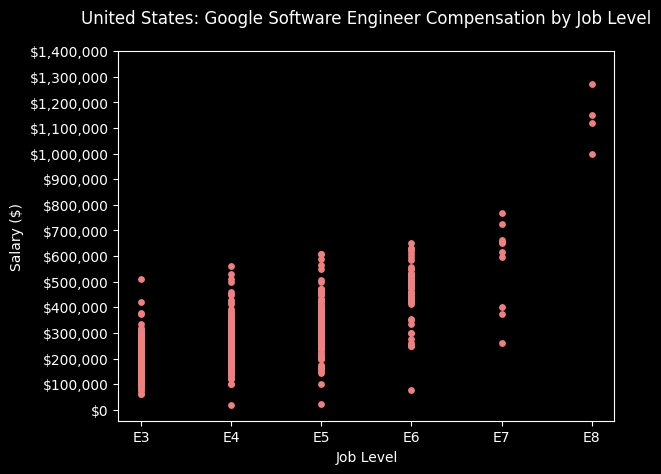

In [135]:
colors = {1:"lightcoral",2:"orange",3:"yellow",4:"palegreen",5:"skyblue",6:"plum"}
thousands = ["$0","$100,000","$200,000","$300,000","$400,000","$500,000","$600,000","$700,000","$800,000","$900,000","$1,000,000","$1,100,000","$1,200,000","$1,300,000","$1,400,000"]
plt.style.use("dark_background")

plt.scatter(df["Level"],df["Salary"],c="lightcoral",s=15)
plt.title("United States: Google Software Engineer Compensation by Job Level",pad=20)
plt.xlabel("Job Level")
plt.ylabel("Salary ($)")
plt.ticklabel_format(axis='both', style='plain')
plt.yticks([i for i in range(0,1500000,100000)],thousands)
plt.xticks([1,2,3,4,5,6],['E3','E4','E5','E6','E7','E8'])
plt.show()

## Graph Analysis
By viewing by job level, its visible that the growth is exponential which is expected. Especially at senior positions. You can see this through the density of the points being scattered, as the job level goes up, the more densely packed areas are higher up

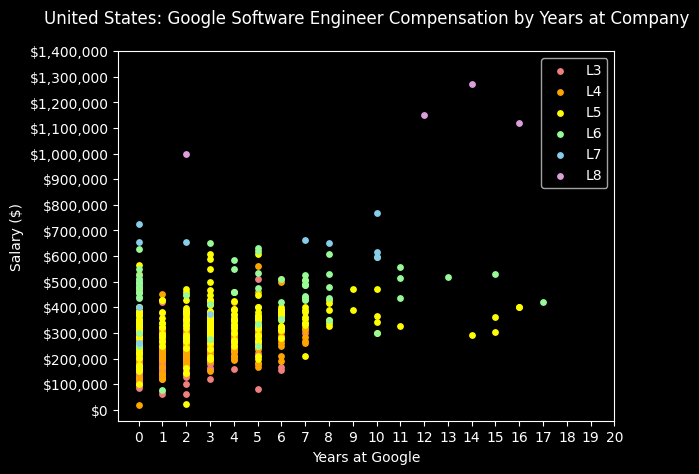

In [136]:
valid_levels = {'L3':1,'L4':2,'L5':3,'L6':4,'L7':5,'L8':6}
level_strings = {1:'L3',2:'L4',3:'L5',4:'L6',5:'L7',6:'L8'}
fig, ax = plt.subplots()
for color in colors:
    data = df[df["Level"]==color]
    ax.scatter(data["Years at Company"],data["Salary"],c=colors[color],label=level_strings[color],s=15)
ax.set_title("United States: Google Software Engineer Compensation by Years at Company",pad=20)
ax.set_yticks([i for i in range(0,1500000,100000)],thousands)
ax.set_xticks([i for i in range(21)])
ax.set_xlabel("Years at Google")
ax.set_ylabel("Salary ($)")
ax.legend()
plt.show()

## Graph Analysis
From here, as expected the longer you work at the Google, the higher your compensation will be. Its important to note this is not always a determining factor though. Observe the L8 senior position with only 3 years at Google. Someone can come into the company with a lot of external experience and get a good offer.

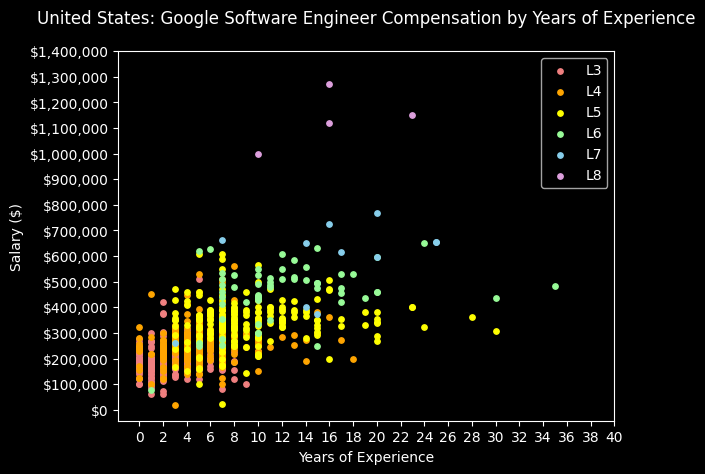

In [137]:
fig, ax = plt.subplots()
for color in colors:
    data = df[df["Level"]==color]
    ax.scatter(data["Years of Experience"],data["Salary"],c=colors[color],label=level_strings[color],s=15)
ax.set_title("United States: Google Software Engineer Compensation by Years of Experience",pad=20)
ax.set_yticks([i for i in range(0,1500000,100000)],thousands)
ax.set_xticks([i for i in range(0,41,2)])
ax.set_xlabel("Years of Experience")
ax.set_ylabel("Salary ($)")
ax.legend()
plt.show()

## Graph Analysis
Once again as expected, more years of experience means higher pay. As shown here, the lower level compensation, and job levels are much more prevalent with less years, while the higher level offers are found much more frequently later on.

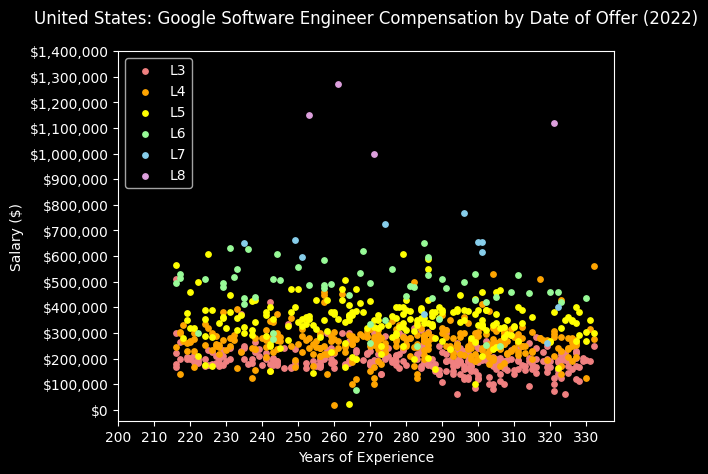

In [138]:
fig, ax = plt.subplots()
for color in colors:
    data = df[df["Level"]==color]
    ax.scatter(data["Days Into Year"],data["Salary"],c=colors[color],label=level_strings[color],s=15)
ax.set_title("United States: Google Software Engineer Compensation by Date of Offer (2022)",pad=20)
ax.set_yticks([i for i in range(0,1500000,100000)],thousands)
ax.set_xticks([i for i in range(200,331,10)])
ax.set_xlabel("Years of Experience")
ax.set_ylabel("Salary ($)")
ax.legend()
plt.show()

## Graph Analysis
This independent variable was a little bit more of a test however the data was a bit to limited to have a larger range of offer dates. With a wider range a data, it would be interesting to see if economic trends result in different salaries. Despite this, there is still a negative line of best fit that is visible in the trend, which could be indicative of the recent tech company layoffs / pay reductions

# Making a machine learning models to predict a salary

In [139]:
df.head()

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,275950.0,2.0,332.0,0.0,4.0
1,560000.0,2.0,332.0,5.0,8.0
2,300000.0,3.0,332.0,4.0,6.0
3,250000.0,1.0,332.0,3.0,3.0
4,316000.0,2.0,331.0,1.0,5.0


Here, we use a standard scaler to standardize all the data, as the range of numbers for all the variables are all very different. We also split into a test and training set so we can observe how accurate the predictions are when ran on the test set.

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#setting a seed to so same answers every time
np.random.seed(42)
x_train, x_test, y_train, y_test= train_test_split(df.iloc[:,1:],df.iloc[:,0], test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)
scaler = StandardScaler()
Y_train = (y_train - y_train.mean()) / y_train.std()
Y_test = (y_test - y_train.mean()) / y_train.std()

Here are the results, with the r2 score and the first 20 predictions compared to the actual salary, lets discuss these

In [141]:
from sklearn.metrics import r2_score
linReg = LinearRegression()
linReg.fit(X_train,Y_train)
y_test_pred = linReg.predict(X_test)
print(f'R^2 for linear regression : {r2_score(Y_test,y_test_pred)}')

for i in range(20):
    print(f'Actual Salary: {y_test.values[i]}, Predicted Salary: {y_test_pred[i]*y_train.std()+y_train.mean()}')

R^2 for linear regression : 0.5445247146917486
Actual Salary: 120000.0, Predicted Salary: 177197.2448660941
Actual Salary: 360000.0, Predicted Salary: 375468.09157997416
Actual Salary: 218000.0, Predicted Salary: 192256.28744074237
Actual Salary: 150000.0, Predicted Salary: 175862.09907150094
Actual Salary: 280000.0, Predicted Salary: 281957.3782718223
Actual Salary: 243000.0, Predicted Salary: 266416.3241040727
Actual Salary: 323250.0, Predicted Salary: 347072.64240672963
Actual Salary: 460000.0, Predicted Salary: 292867.88511949417
Actual Salary: 197000.0, Predicted Salary: 175458.40873342042
Actual Salary: 120000.0, Predicted Salary: 192011.89560248045
Actual Salary: 440000.0, Predicted Salary: 468978.80488812603
Actual Salary: 252000.0, Predicted Salary: 292615.5723885235
Actual Salary: 195453.0, Predicted Salary: 187774.29432155093
Actual Salary: 275000.0, Predicted Salary: 260728.90678308677
Actual Salary: 156250.0, Predicted Salary: 257892.5446106594
Actual Salary: 269000.0, Pre

# Results
Unforunately, it seems that all of these factors were not the best as predicting salary, but atleast show some correlation to salary. Another issue here, is I believe not all of the salary data is very accurate. Levels.fyi cannot stop anyone from lying. Furthermore, levels.fyi table only is the 1000 most recent entries, so we are limited to the data we can collect. If there was more data to work with, it could be divided into job title, and other factors as well. As well as showing how salaries have changed over time.

Ultimately though, this is a very good groundwork for a interesting model that could be used to accurate predict what someone should be getting paid, and could be useful if more refined.